# Training a Jet Tagging with **CNN** 

---
In this notebook, we perform a Jet identification task using a multiclass classifier based on a 
Dense Neural Network (DNN). The problem consists on identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on set of physics-motivated high-level features.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

For details on the dataset, see Notebook1

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

nb, if you are running locally you can skip the step below and change the paths later to point to the folder with your previous download of the datasets.

In [19]:
! curl https://cernbox.cern.ch/index.php/s/xmTytsMPvCEA6Ar/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz 
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0  333M    0 3059k    0     0   246k      0  0:23:03  0:00:12  0:22:51  369kk      0  0:35:14  0:00:07  0:35:07  267k:23:33  372k^C
x Data-MLtutorial/
x Data-MLtutorial/JetDataset/
x Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5: truncated gzip input
tar: Error exit delayed from previous errors.
jetImage_7_100p_0_10000.h5     jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5 jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5 jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5 jetImage_7_100p_80000_90000.h5


In [3]:
target = np.array([])
features = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myFeatures = np.array(f.get("jets")[:,[12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52]])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, features.shape)

Appending Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 16)


The dataset consists of 50000 jets, each represented by 16 features

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del features, target

(33500, 16) (16500, 16) (33500, 5) (16500, 5)


# DNN model building

In [7]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [8]:
input_shape = X_train.shape[1]
dropoutRate = 0.25

In [9]:
####
inputArray = Input(shape=(input_shape,))
#
x = Dense(40, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)
#
x = Dense(20)(x)
x = Activation('relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputArray, outputs=output)

2022-05-04 18:48:10.058259: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 40)                680       
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 activation (Activation)     (None, 20)                0         
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                210   

We now train the model

In [13]:
batch_size = 128
n_epochs = 50

In [14]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/10
262/262 - 1s - loss: 3.5481 - val_loss: 1.6099 - lr: 0.0010 - 929ms/epoch - 4ms/step
Epoch 2/10
262/262 - 0s - loss: 1.6373 - val_loss: 1.6065 - lr: 0.0010 - 339ms/epoch - 1ms/step
Epoch 3/10
262/262 - 0s - loss: 1.6181 - val_loss: 1.5849 - lr: 0.0010 - 349ms/epoch - 1ms/step
Epoch 4/10
262/262 - 0s - loss: 1.5807 - val_loss: 1.4861 - lr: 0.0010 - 362ms/epoch - 1ms/step
Epoch 5/10
262/262 - 0s - loss: 1.5272 - val_loss: 1.4437 - lr: 0.0010 - 317ms/epoch - 1ms/step
Epoch 6/10
262/262 - 0s - loss: 1.5048 - val_loss: 1.4296 - lr: 0.0010 - 333ms/epoch - 1ms/step
Epoch 7/10
262/262 - 0s - loss: 1.4857 - val_loss: 1.4078 - lr: 0.0010 - 331ms/epoch - 1ms/step
Epoch 8/10
262/262 - 0s - loss: 1.4673 - val_loss: 1.3879 - lr: 0.0010 - 439ms/epoch - 2ms/step
Epoch 9/10
262/262 - 0s - loss: 1.4539 - val_loss: 1.3804 - lr: 0.0010 - 359ms/epoch - 1ms/step
Epoch 10/10
262/262 - 0s - loss: 1.4399 - val_loss: 1.3642 - lr: 0.0010 - 385ms/epoch - 1ms/step


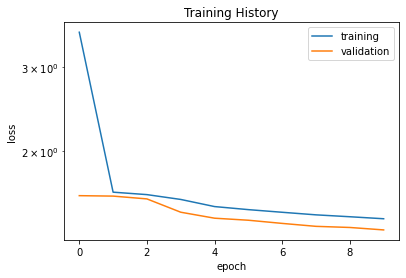

In [15]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

To save on disk the best model and training results:

model_json = model.to_json()

with open("tutorials/HiggsSchool/models/jetTagger_DNN.json", "w") as json_file:

    json_file.write(model_json)
    
model.save_weights("tutorials/HiggsSchool/models/jetTagger_DNN.h5")

# Building the ROC Curves

In [16]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

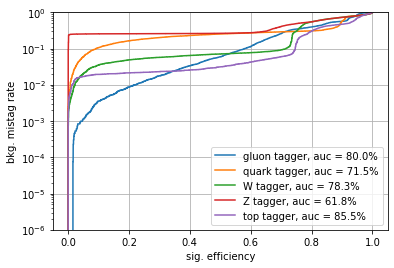

In [18]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()